In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="mkl")

In [2]:
# import numpy, pandas, matplotlib, pytorch, pytorch distributions and sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import jax.tree_util as jtu

In [24]:
device = "cpu"

## Heteroskedatic Neural Network Regression Models.

In [7]:
class HeteroskedasticNN(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 2)  # we learn both mu and log_noise_std

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        z = self.fc3(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std

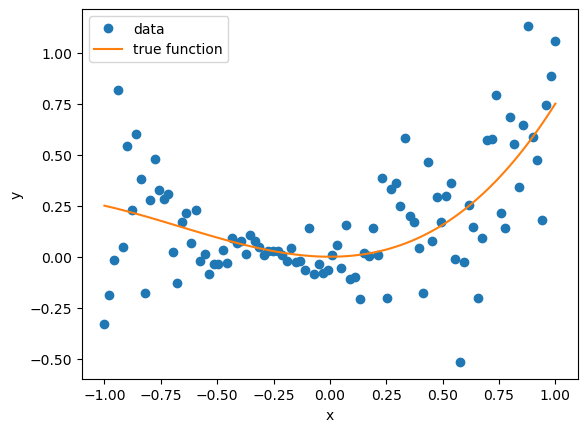

In [17]:
torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * (0.1 + 0.4 * x_lin)

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)

# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), "o", label="data")
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

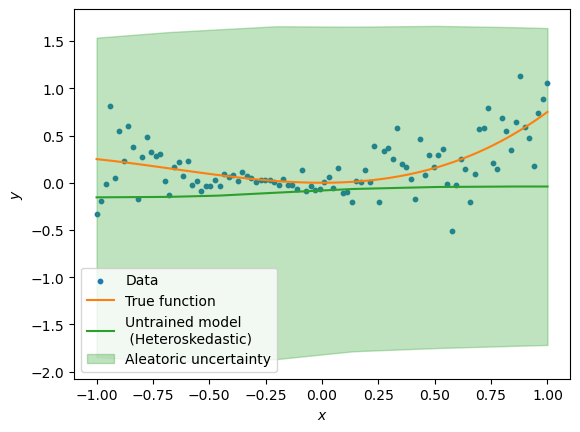

In [20]:
# Now, fit the heteroskedastic model

heteroskedastic_model = HeteroskedasticNN().to(device)

# Plot the untrained model
with torch.no_grad():
    y_hat, log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Untrained model\n (Heteroskedastic)")

In [11]:
def plot_results(y_hat, epistemic_std=None, aleatoric_std=None, model_name=""):
    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color="C0", label="Data")
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color="C1", label="True function")
    plt.plot(x_lin.cpu(), y_hat.cpu(), color="C2", label=model_name)
    if epistemic_std is not None:
        plt.fill_between(
            x_lin.cpu(),
            (y_hat - 2 * epistemic_std).cpu(),
            (y_hat + 2 * epistemic_std).cpu(),
            alpha=0.3,
            color="C3",
            label="Epistemic uncertainty",
        )
    if aleatoric_std is not None:
        plt.fill_between(
            x_lin.cpu(),
            (y_hat - 2 * aleatoric_std).cpu(),
            (y_hat + 2 * aleatoric_std).cpu(),
            alpha=0.3,
            color="C2",
            label="Aleatoric uncertainty",
        )

    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()

In [21]:
# Train the model
params = list(heteroskedastic_model.parameters())

train_fn(
    heteroskedastic_model,
    loss_heteroskedastic,
    params,
    x_lin[:, None],
    y,
    n_epochs=1000,
    lr=0.01,
)

Epoch 0: loss 0.873
Epoch 50: loss 0.019
Epoch 100: loss -0.254
Epoch 150: loss -0.366
Epoch 200: loss -0.401
Epoch 250: loss -0.441
Epoch 300: loss -0.470
Epoch 350: loss -0.485
Epoch 400: loss -0.494
Epoch 450: loss -0.501
Epoch 500: loss -0.503
Epoch 550: loss -0.506
Epoch 600: loss -0.499
Epoch 650: loss -0.508
Epoch 700: loss -0.503
Epoch 750: loss -0.509
Epoch 800: loss -0.506
Epoch 850: loss -0.511
Epoch 900: loss -0.509
Epoch 950: loss -0.511


-0.5111914277076721

In [14]:
def train_fn(model, loss_func, params, x, y, n_epochs=1000, lr=0.01):
    parameter_leaves = jtu.tree_leaves(params)
    optimizer = torch.optim.Adam(parameter_leaves, lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_func(model, x, y, params)
        loss.backward()
        optimizer.step()
        # Print every 10 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: loss {loss.item():.3f}")
    return loss.item()

In [22]:
def loss_heteroskedastic(model, x, y, params):
    mu_hat, log_noise_std = model(x)
    noise_std = torch.exp(log_noise_std)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()

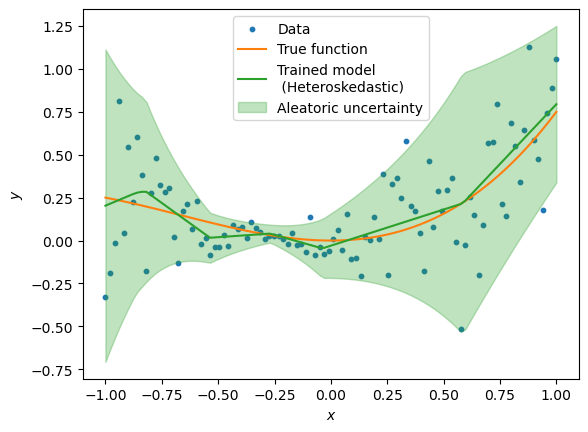

In [23]:
# Plot the trained model
with torch.no_grad():
    y_hat, log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat, aleatoric_std=aleatoric_std, model_name="Trained model\n (Heteroskedastic)")